## Part 1: 
Load data, clean, and save aggregate data

In [1]:
#!pip install supertree

import dtreeviz

import pandas as pd 
import os
import numpy as np
import pickle
from data_cleaning import change_columns_types
from data_loading import aggregate_data
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#immport necessary libraries and filter warnings
import warnings
 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import nfl_data_py as nfl
from sklearn.impute import SimpleImputer
from utility_db_25 import mark_columns, TrainML, build_catboost, optuna_call, test_ML, build_transformer, get_momentum_cols, create_momentum_index, get_final_features, get_motion_cols, motion_complexity_score
from team_logos import graph_run_pass, get_logo_df, load_previous_year_passruns
warnings.filterwarnings("ignore")

In [2]:
#graph_run_pass()

In [3]:
root_dir = os.getcwd()

load_saved_data = False # if you change this to true you can load presaved data
games_fname= os.path.join(root_dir, "data/games.csv")
plays_fname = os.path.join(root_dir,  "data/plays.csv")

if not load_saved_data: 
    players_fname = os.path.join(root_dir,  "data/players.csv")
    player_plays_fname = os.path.join(root_dir,  "data/player_play.csv")
    c21_fname = os.path.join(root_dir, 'data_21/cov_21.csv')
    pr21_fname = os.path.join(root_dir, 'data_21/team_pr_21.csv')
    xp_fname = os.path.join(root_dir, "data/team_xpass_ratios.csv")
    pr_fname = os.path.join(root_dir, "data/team_pass_rates.csv")
    cf_fname = os.path.join(root_dir, "data/coverages_faced.csv")
    cu_fname = os.path.join(root_dir, 'data/coverages_used.csv')
    inj_fname = os.path.join(root_dir, 'data/snaps_lost_injury.csv')
    qbr_fname = os.path.join(root_dir, 'data/qbr_data.csv')
    def_fname_train = os.path.join(root_dir, 'data/def_train.csv')
    def_fname_test = os.path.join(root_dir, 'data/def_test.csv')
    tracking_fname_list_train = [os.path.join(root_dir,  f"data/tracking_week_{i}.csv") for i in range(1,9)] #weeks 1-8 are training data
    tracking_fname_list_test = [os.path.join(root_dir,  "data/tracking_week_9.csv")] #week 9 is test data
    train_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_train, games_fname, xp_fname, pr_fname, cu_fname,inj_fname, c21_fname, pr21_fname, qbr_fname, def_fname_train, 'train')
    train_data.to_csv(os.path.join(root_dir, "data/train_data.csv"), index=False)
    test_data=aggregate_data(plays_fname, player_plays_fname, players_fname, tracking_fname_list_test, games_fname, xp_fname, pr_fname, cu_fname,inj_fname, c21_fname, pr21_fname, qbr_fname, def_fname_test, 'test')
    test_data.to_csv(os.path.join(root_dir, "data/test_data.csv"), index=False)
else:
    train_data=pd.read_csv(os.path.join(root_dir, "data/train_data.csv"))
    test_data=pd.read_csv(os.path.join(root_dir, "data/test_data.csv"))
print('train colums: ', len(train_data.columns))
print('test colums: ', len(test_data.columns))

2022 done.
Downcasting floats.
2022 done.
Downcasting floats.
Downcasting floats.
INFO: Labeling plays as runs or passes
2022 done.
Downcasting floats.
Downcasting floats.
2022 done.
Downcasting floats.
2022 done.
Downcasting floats.
2022 done.
Downcasting floats.
Downcasting floats.
INFO: Labeling plays as runs or passes
2022 done.
Downcasting floats.
Downcasting floats.
2022 done.
Downcasting floats.
train colums:  463
test colums:  367


In [4]:
include_columns=[x for x in test_data.columns if '_def' not in x]+['pass_rate_def']
train_data=train_data[include_columns]
test_data = test_data[include_columns]

In [5]:
motion_cols, rb_motion_cols=get_motion_cols(train_data.columns)
momentum_cols, rb_cols=get_momentum_cols(train_data.columns)

train_data=create_momentum_index(train_data, momentum_cols, rb_cols)
test_data=create_momentum_index(test_data, momentum_cols, rb_cols)

train_data=motion_complexity_score(train_data, motion_cols, rb_motion_cols)
test_data=motion_complexity_score(test_data, motion_cols, rb_motion_cols)

In [6]:
train_data[['off_xpass','box_ewm_dl_bmi','qb_pass_rate_ewm','tempo']].isna().sum()

off_xpass             0
box_ewm_dl_bmi        0
qb_pass_rate_ewm    106
tempo                 0
dtype: int64

In [7]:
train_data['xpass_bmi'] = train_data['off_xpass']-train_data['box_ewm_dl_bmi']#-.4*train_data['qb_pass_rate_ewm']
test_data['xpass_bmi'] = test_data['off_xpass']-test_data['box_ewm_dl_bmi']#-.4*test_data['qb_pass_rate_ewm']
train_data['contextual_tempo'] = train_data['tempo'] +train_data['xpass_bmi']
test_data['contextual_tempo'] = test_data['tempo'] +test_data['xpass_bmi']
train_data['backfield_ind'] = -train_data['n_offense_backfield'] +train_data['QB_RB1_offset']
test_data['backfield_ind'] = -test_data['n_offense_backfield'] +test_data['QB_RB1_offset']

In [8]:
def calc_ipa (data):
    ipa = (.7* data['a|max|QB_1'] + .2*data['run_val'] + \
            data['receiverAlignment_2x2'] + data['motionSinceLineset|RB_2']\
            + .1*data['s|max|G_2'] + data['surface_fieldturf'] + .05*data['time_remaining']).values
    return ipa

train_data['ipa'] = calc_ipa(train_data)
test_data['ipa'] = calc_ipa(test_data)

## Goal: 
To predict pass attempts for each play with greater accuracy and precision than the baseline dummy classifier. The base rate is about 60%. We will look at the offensive players' tracking data, along with characteristics of the play including the offensive formation and receiver alignment.

## General Strategy:
1. Read all data
2. Merge data
3. Filter data for offensive players, plays not nullified by a penalty, and data before the snap
4. Create a target variable 'pass' to indicate if a pass was attempted
5. Feature engineering and feature selection
6. Test baseline models
7. Tune models

In [9]:

for col in train_data.columns: 
    if col != 'pass':
        if round((train_data[col].isna().sum() /len(train_data)*100), 2)>75:
            train_data.drop(columns=col, inplace=True)
        elif round((train_data[col].isna().sum() /len(train_data)*100), 2)>0:
            print(col,round((train_data[col].isna().sum() /len(train_data)*100), 2), '% missing')
        else: 
            continue

pass_rush_ratio 2.84 % missing
temp 9.67 % missing
humidity 5.64 % missing
wind 8.97 % missing
qb_pa_rate_pass 0.73 % missing
qb_pass_rate_ewm 0.73 % missing


In [10]:
train_data=change_columns_types(train_data)
test_data=change_columns_types(test_data)

In [11]:
len(train_data)

14556

In [12]:
final_features=get_final_features(train_data,threshold=.5,trim_rows=0)

In [13]:
train_data['mm_inv'] = 1/train_data['motion-momentum']
test_data['mm_inv'] = 1/test_data['motion-momentum']

In [14]:
df_15 = pd.read_csv('data/top_2_player_diff_last_10.csv')

In [15]:
train_data = train_data.merge(df_15,how='left')
test_data = test_data.merge(df_15,how='left')

In [16]:
#final_features.remove('xpass_situational')

In [17]:
#final_features.remove('down')
#final_features.remove('yardsToGo')

In [18]:
len(final_features)

24

In [19]:
final_features

['receiverAlignment_3x2',
 'x_standard|mean|RB_1_QBdiff',
 'QBdff_T',
 'a|max|TE_3',
 's|max|QB_1',
 'mean_DL_bmi',
 'motion-momentum',
 'down',
 'pass',
 'yardsToGo',
 'tempo',
 'xpass_bmi',
 'QBdff_WR',
 'a|max|TE_2',
 'mean_pairwise_dist',
 'x_standard|mean|T_1_QBdiff',
 'xpass_situational',
 'QBdffy_RB',
 'is_motion',
 'neg_Formations',
 's|max|RB_1',
 'a|max|FB_1',
 'neg_alignment',
 'a|max|WR_3']

In [20]:
len(train_data)

14556

In [21]:
final_features=['pass','xpass_situational',#'receiverAlignment_3x2' #'QBdffy_RB', 'QBdff_T', 
        'motion-momentum','contextual_tempo', # 'xpass_bmi',#'qb_pass_rate_ewm','ipa','off_xpass',
        'neg_Formations', 'mean_pairwise_dist']
numeric_columns, cat_columns = mark_columns(df=train_data,features=final_features, nc=None,cc = None)

<Axes: title={'center': 'Correlation Heatmap of Features'}>

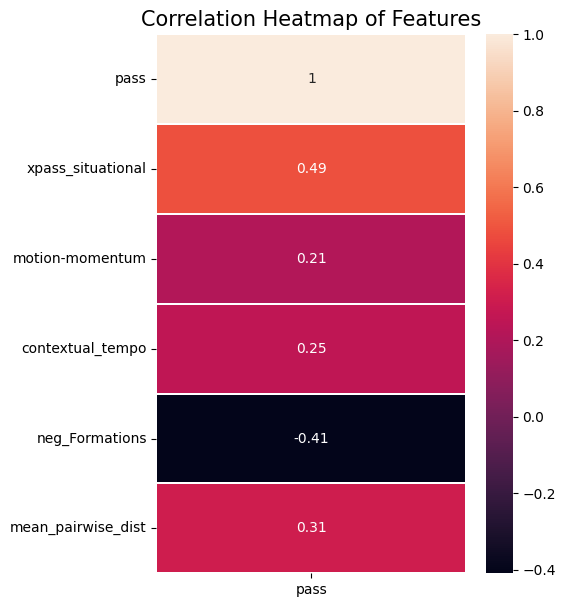

In [22]:
#!pip install seaborn
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,7))
plt.title('Correlation Heatmap of Features', size=15)

sns.heatmap(train_data[final_features].corr()[['pass']],linewidths=0.1,vmax=1.0,  linecolor='white', annot=True)

In [23]:
# Create an imputer object with mean strategy
#imputer = SimpleImputer(strategy='mean')
from sklearn.compose import ColumnTransformer


# Fit and transform the data
#merged_pivot[numeric_columns] = imputer.fit_transform(merged_pivot[numeric_columns])
imputer = SimpleImputer(missing_values = np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, numeric_columns),('scaler', MinMaxScaler(), numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [24]:
#create a function to train ML models and return ROC_AUC and accuracy scores
SEED=42
n_splits=5
#X=merged_pivot[selected_features]
X=train_data[final_features].drop(columns='pass')

y=train_data['pass']

Training Folds: 100%|██████████| 5/5 [00:00<00:00, 61.06it/s]

Mean Train AUC --> 0.5000
Mean Validation AUC ---> 0.5000
Mean Train Accuracy --> 0.6046
Mean Validation Accuracy ---> 0.6046


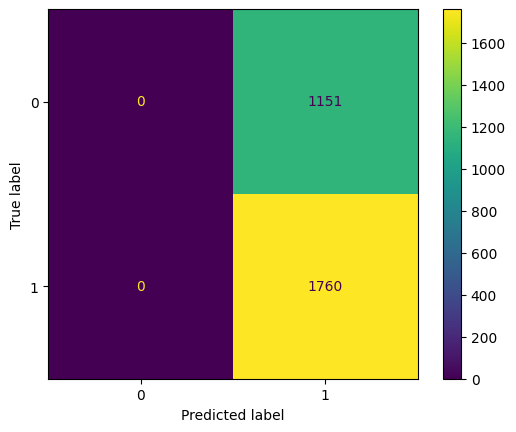

In [25]:
#get baseline value from dummy classifier
dummypipeline=Pipeline([('tr', transformer), ('dummy', DummyClassifier(strategy="most_frequent"))], verbose = True)
TrainML(dummypipeline,X, y, n_splits,SEED)

Training Folds: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]

Mean Train AUC --> 0.8040
Mean Validation AUC ---> 0.7553
Mean Train Accuracy --> 0.8167
Mean Validation Accuracy ---> 0.7704


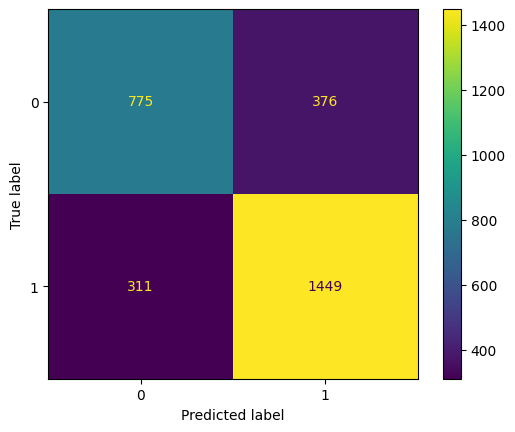

In [26]:
#lgbm classifier
pipeline=Pipeline([('tr', transformer), ('lgbm', LGBMClassifier(verbosity=-1))], verbose = True)
lgb = LGBMClassifier(verbosity=-1,seed=42).fit(X,y)
TrainML(pipeline,X, y,n_splits,SEED)

In [27]:
final_features.remove('pass')

In [28]:
from catboost import  Pool, MetricVisualizer
import ipywidgets as widgets
%matplotlib inline
#need graphviz for this part and to add to path https://graphviz.org/download/

# For explicitly displaying widgets
from IPython.display import display
import lightgbm

#lightgbm.plot_tree(lgb, tree_index=1,dpi=300, ax=ax[1])

In [29]:
ff_pre=[ 'xpass_situational','a_mean','n_offense_backfield', #'a_max',#'QB_RB1_offset',#'receiverAlignment_3x2' #'QBdffy_RB', 'QBdff_T', 
        'motion-momentum','contextual_tempo', # 'xpass_bmi',#'qb_pass_rate_ewm','ipa','off_xpass',
        'neg_Formations', 'mean_pairwise_dist']#,'tempo']


In [30]:
final_features = ['Situational xPass','FAD',"# of RB's",'RMV','TICK','Run Formation Flag','DCI']

In [31]:
rnd = dict(zip(ff_pre,final_features))
train_data = train_data.rename(columns=rnd)
test_data = test_data.rename(columns=rnd)
rnd

{'xpass_situational': 'Situational xPass',
 'a_mean': 'FAD',
 'n_offense_backfield': "# of RB's",
 'motion-momentum': 'RMV',
 'contextual_tempo': 'TICK',
 'neg_Formations': 'Run Formation Flag',
 'mean_pairwise_dist': 'DCI'}

In [32]:
final_numeric_columns, final_cat_columns = mark_columns(df=train_data,features=final_features, nc=numeric_columns,cc = cat_columns)

In [33]:
from sklearn.compose import ColumnTransformer
# Create a transformer
imputer = SimpleImputer(missing_values=np.nan,strategy='mean')
transformer = ColumnTransformer(
    transformers=[('imputer', imputer, final_numeric_columns),
        ('scaler', MinMaxScaler(), final_numeric_columns)
    ],
    remainder='passthrough'  # Pass through columns not specified
)

In [34]:
SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
#best_features=['xpass_situational', 'presnap_motion_complexity', 'presnap_momentum', 'receiverAlignment_3x2', 'offenseFormation_SINGLEBACK']

X=train_data[final_features]

y=train_data['pass']
# Define the helper function so that it can be reused

#cat_params = optuna_call(transformer,X,y,SKF,n_trials=20)

In [35]:
transformer_impute = build_transformer(imputer,numeric_columns,kind='imputer')
transformer_scale = build_transformer(imputer,numeric_columns,kind='scaler')

### Get proper validation indicies

Using week 8 holdout:

In [36]:
# import relevant play/week info
plays_df = pd.read_csv(plays_fname)[['gameId','playId']]
games_df = pd.read_csv(games_fname)[['gameId','week']]
id_week = plays_df.merge(games_df,how='left')

# mark train data with week info
train_marked = train_data.merge(id_week,how='left')

In [37]:
len(train_marked)

14556

Use only week 2 onward:

In [38]:
# truncate to week 2 on, get length of week 8
train_trunc = train_marked.loc[train_marked[(train_marked['week'] >=3)].index]
w8_len = len(train_trunc[train_trunc['week'] == 8].index)

# -1 is train, 1 is holdout, per predefinedsplit parlance
ind_train = [-1]*(len(train_trunc)-w8_len)
ind_val = [1]*w8_len

# sanity check our split
len(ind_train) == len(train_trunc[train_trunc['week'] < 8])
len(ind_train+ind_val) == len(train_trunc)

True

In [39]:
len(train_trunc)

10801

Define our train/val split (by week 8 indices):

In [40]:
cv_ind = ind_train+ind_val
ps = PredefinedSplit(test_fold=cv_ind)

### Redefine our X/y to exclude week 2:

In [41]:
X = train_trunc[final_features]
y = train_trunc['pass']

### Validation grid search:

In [42]:
from sklearn.model_selection import GridSearchCV

# Initialize an empty dictionary to store the best hyperparameters and their values
best_hyperparameters = {}
best_values = {}
 
# Initialize the LightGBM classifier
lgb_classifier = lightgbm.LGBMClassifier(force_col_wise=True, deterministic=True, random_state=42)

# Define a range of values for the hyperparameters to search through
param_grid = {
    'boosting_type' : ['gbdt', 'dart'],
    'num_leaves': [25, 30, 40, 50],
    'learning_rate': [  0.1,.15],
    'max_depth': [4,5,6,7],
    'n_estimators': [75, 100],
    #'is_unbalance': [True],
    'random_state': [42],
    "deterministic": [True]
}


#Initialize GridSearchCV for hyperparameters
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid,
                           scoring='accuracy', cv=ps)
 

# Fit the model to the training data to search for the best hyperparameters
grid_search.fit(X,y)
 
# Get the best hyperparameters and their values
best_params = grid_search.best_params_
best_hyperparameters = list(best_params.keys())
best_values = list(best_params.values())

'''
for i in range(5):
    key = 'split' + str(i) + '_test_score'
    print(np.mean(grid_search.cv_results_[key])
'''

best_params


{'boosting_type': 'gbdt',
 'deterministic': True,
 'learning_rate': 0.15,
 'max_depth': 5,
 'n_estimators': 75,
 'num_leaves': 40,
 'random_state': 42}

In [43]:
grid_search.best_score_

0.7875706214689265

In [44]:
best_params = {'boosting_type': 'dart',
 'max_depth': 4,
 'deterministic': True,
 'learning_rate': 0.1,
 'n_estimators': 75,
 'num_leaves': 50,
 'random_state': 42}

In [45]:
train_data['pass'].value_counts()

1    8801
0    5755
Name: pass, dtype: int64

In [46]:
# Train a LightGBM model with the best hyperparameters
best_model = lightgbm.LGBMClassifier(**best_params)
best_model.fit(X,y)

LGBMClassifier(boosting_type='dart', deterministic=True, max_depth=4,
               n_estimators=75, num_leaves=50, random_state=42)

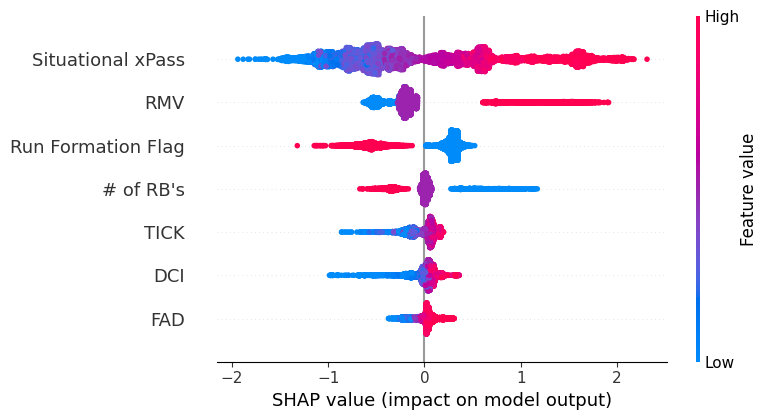

In [47]:
import shap 

shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X)

In [48]:
X_impute=X.fillna(0)
train_marked=train_marked.fillna(0)

In [49]:
#!pip install --upgrade dtreeviz
import dtreeviz
booster = best_model.booster_
viz_model = dtreeviz.model(booster, tree_index=1,
                           X_train=train_marked[final_features], y_train=train_marked['pass'],
                           feature_names=final_features,
                           target_name='pass', class_names=["run", "pass"])

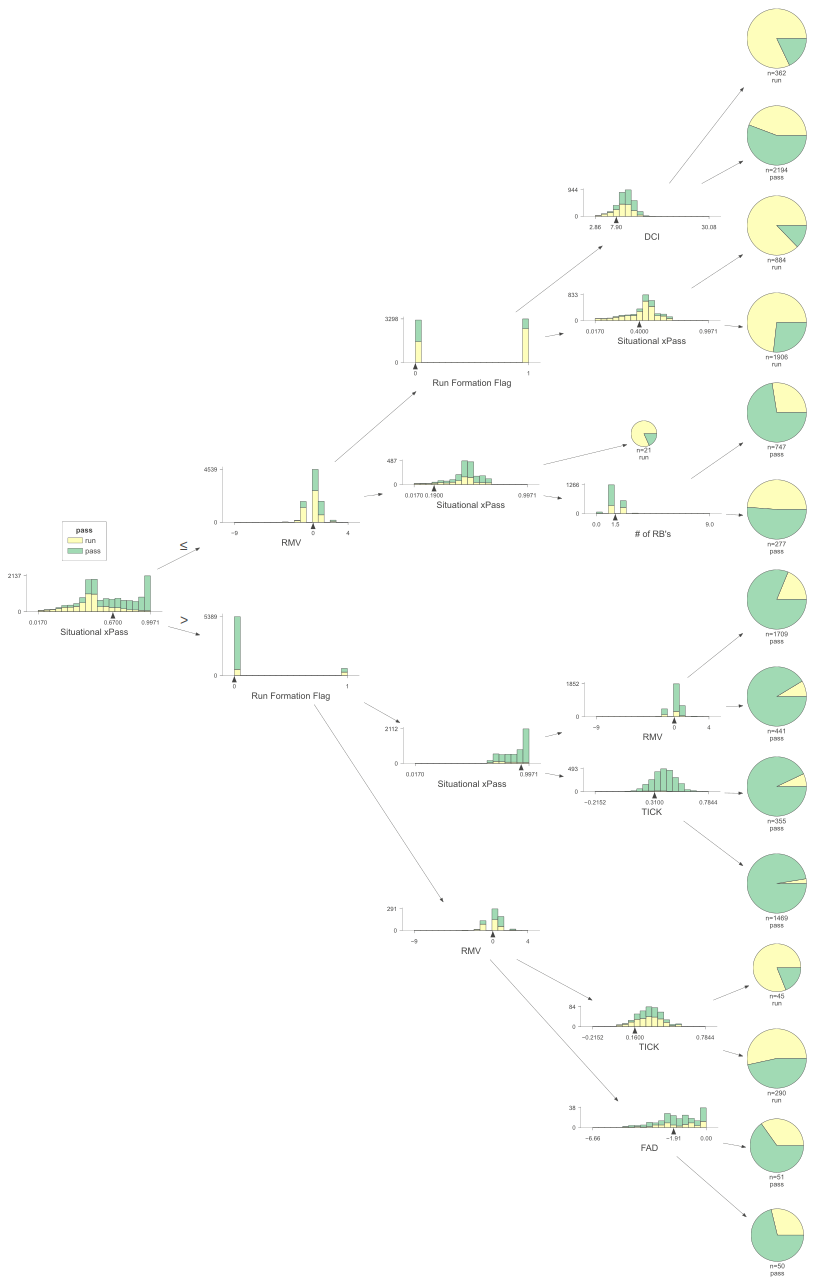

In [50]:
viz_model.view(orientation="LR")

In [51]:
x=train_marked.iloc[561][final_features]

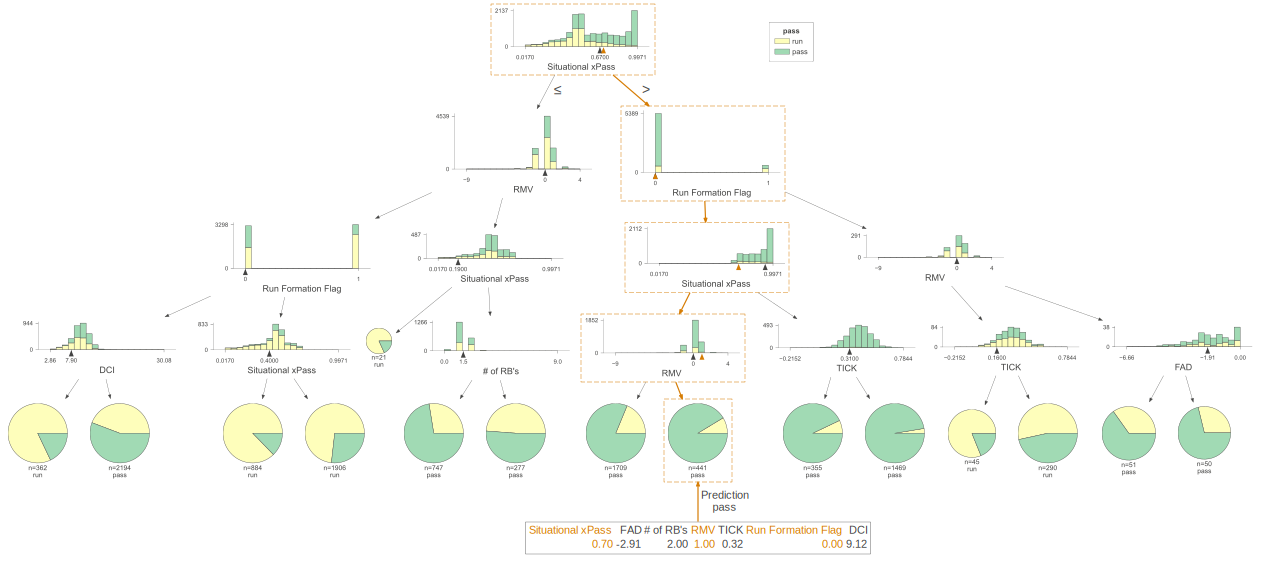

In [52]:

viz_model.view(x=x)


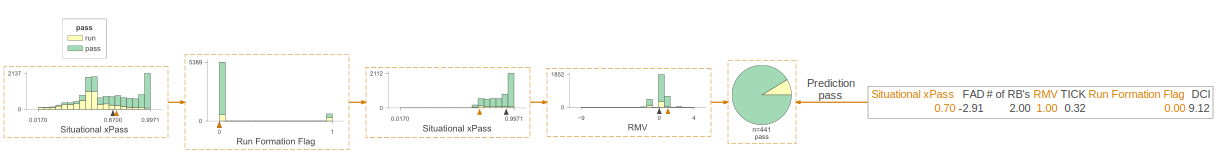

In [53]:
viz_model.view(x=x, show_just_path=True, orientation="LR")

<Axes: >

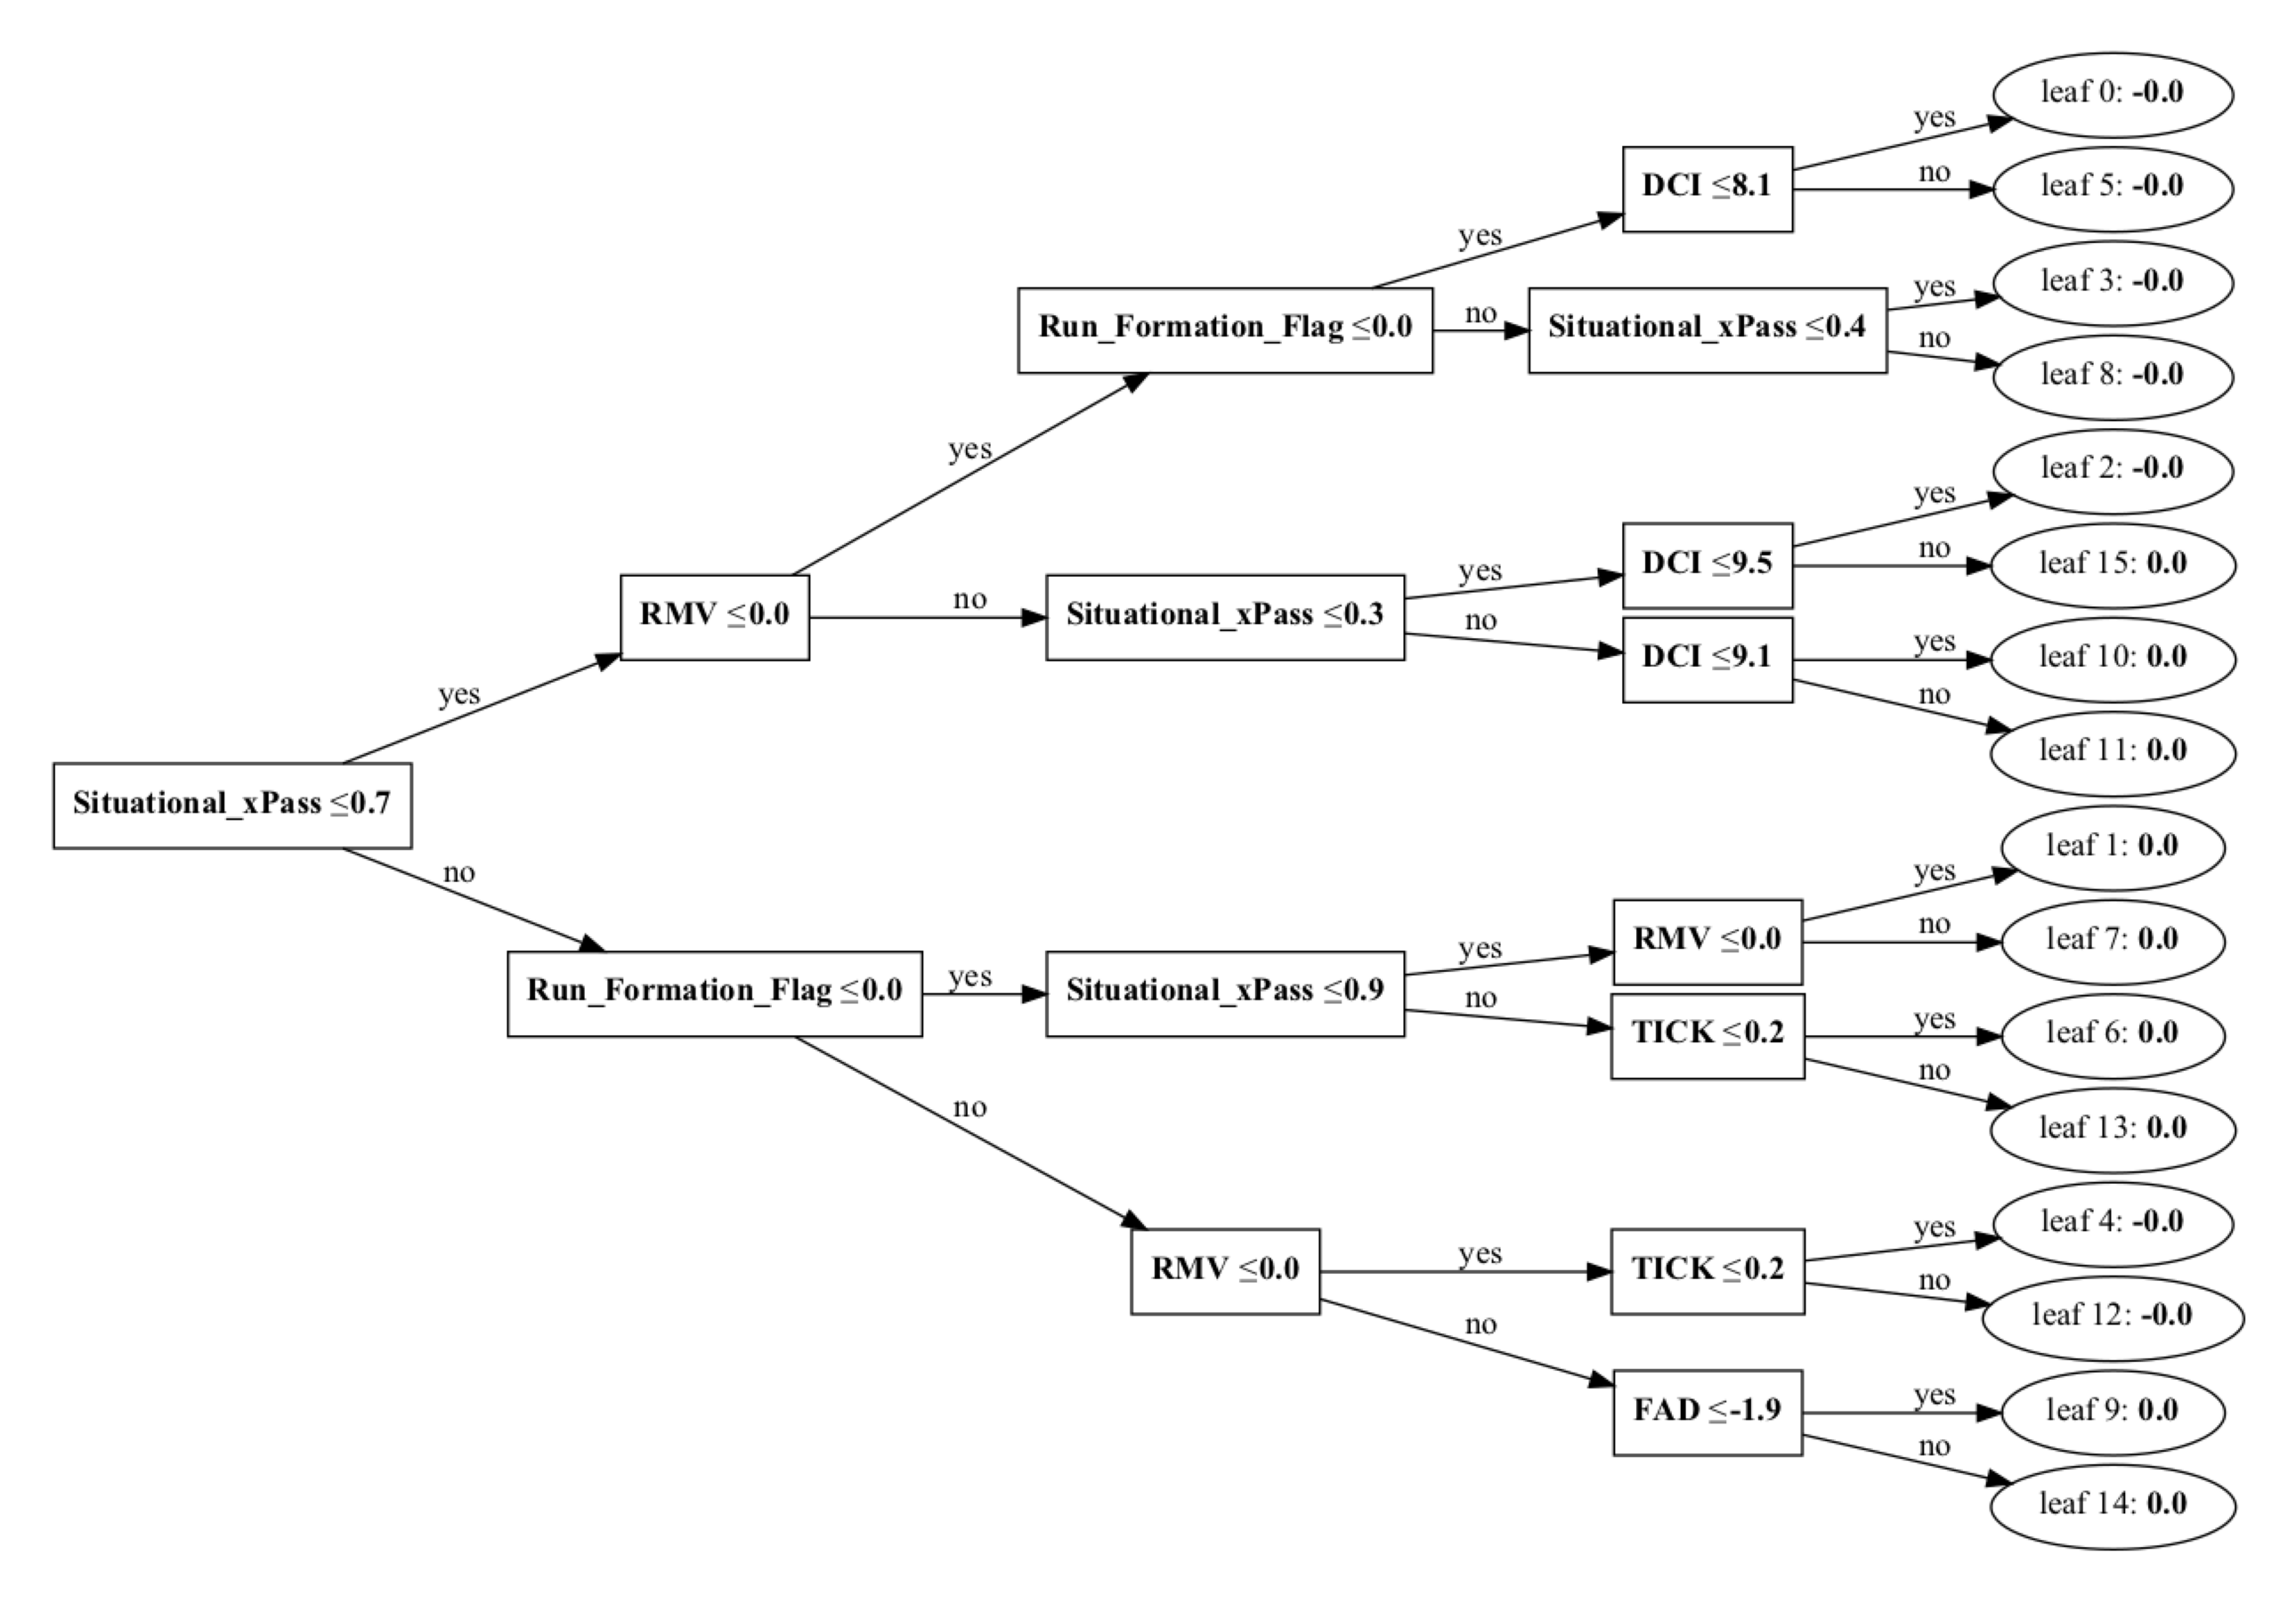

In [54]:
lightgbm.plot_tree(best_model, tree_index=3,dpi=500,precision=1)

In [55]:
y_pred = best_model.predict(test_data[final_features])
y_test = test_data['pass']

In [56]:
accuracy_score(y_test, y_pred)

0.8254901960784313

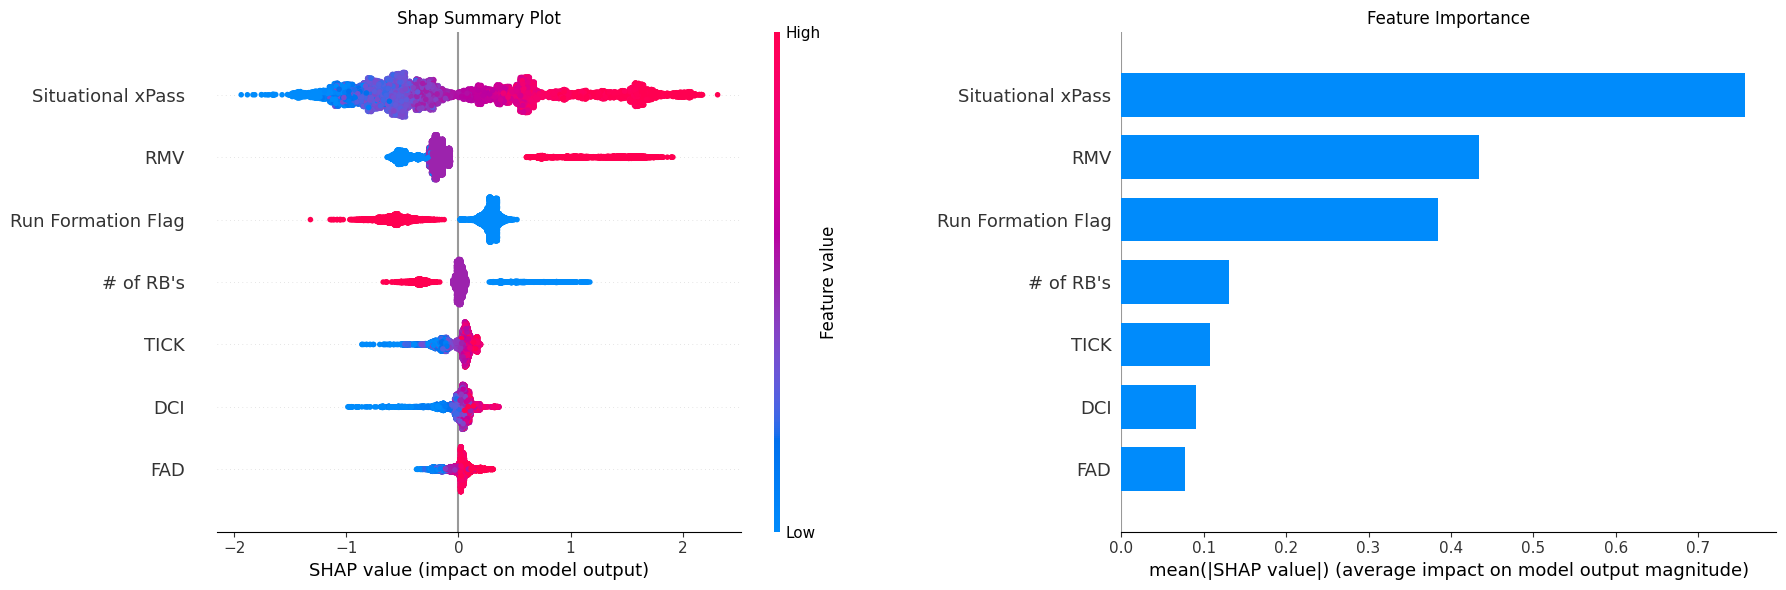

In [57]:

shap_values = shap.TreeExplainer(best_model).shap_values(X)

fig = plt.figure()
ax0 = fig.add_subplot(131)
ax0.set_title("Shap Summary Plot")
shap.summary_plot(shap_values, X, show=False)

ax1 = fig.add_subplot(132)
ax1.set_title("Feature Importance", )
shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar", show=False)

plt.gcf().set_size_inches(27,6)
plt.tight_layout() 
plt.show()

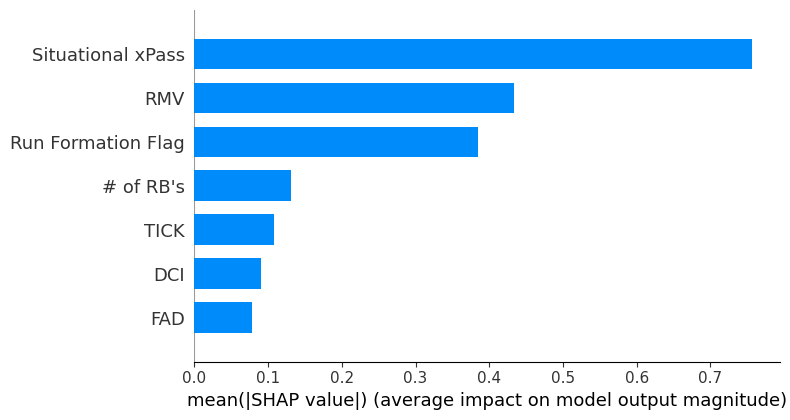

In [58]:
shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
feature_names = final_features


lgbm_resultX = pd.DataFrame(shap_values, columns = feature_names)

vals = np.abs(lgbm_resultX.values).mean(0)

shap_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
shap_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)


In [59]:
shap_importance.head(8).set_index('col_name').T.columns

Index(['Situational xPass', 'RMV', 'Run Formation Flag', '# of RB's', 'TICK',
       'DCI', 'FAD'],
      dtype='object', name='col_name')

AUC --> 0.8175735554767813
Accuracy --> 0.8254901960784313


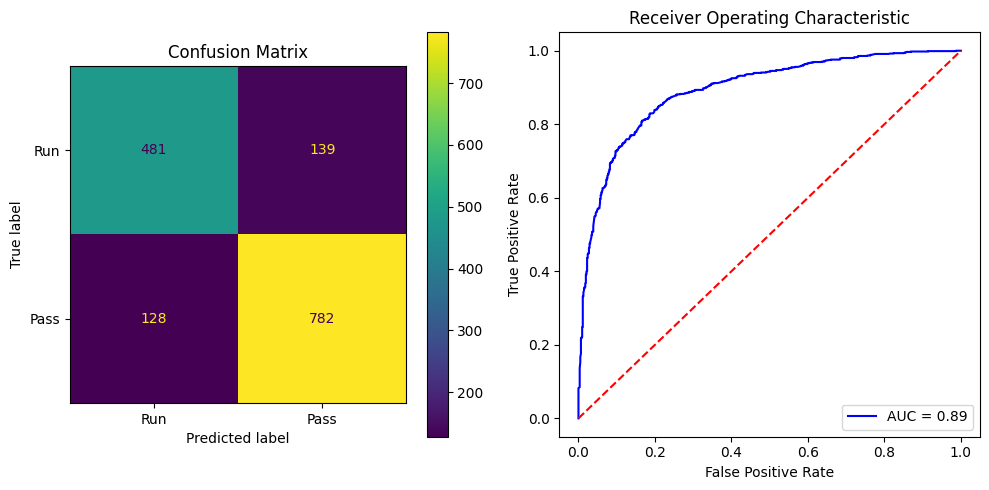

In [60]:
test_ML(test_data, best_model,final_features,transformer_impute,transformer_scale)

Note that xpass_bmi has the highest info gain, if that's worth anything. The intuition is perhaps that, since it's often chosen as one of the last nodes, it thus has an artificially high info gain. Conversely, it seems that tempo is *under*-utilized; perhaps this is an argument for combining the two, such that we get better performance.

In [61]:
# Obtain gain feature importance
gain_importance = best_model.feature_importances_

# Display feature importance with feature names
feature_names = X[final_features]
gain_importance_df = pd.DataFrame({'Feature': final_features, 'Gain': gain_importance})
gain_importance_df.sort_values(by='Gain', ascending=False).head(25).set_index('Feature').T.columns

Index(['Situational xPass', 'RMV', 'TICK', 'DCI', 'FAD', '# of RB's',
       'Run Formation Flag'],
      dtype='object', name='Feature')

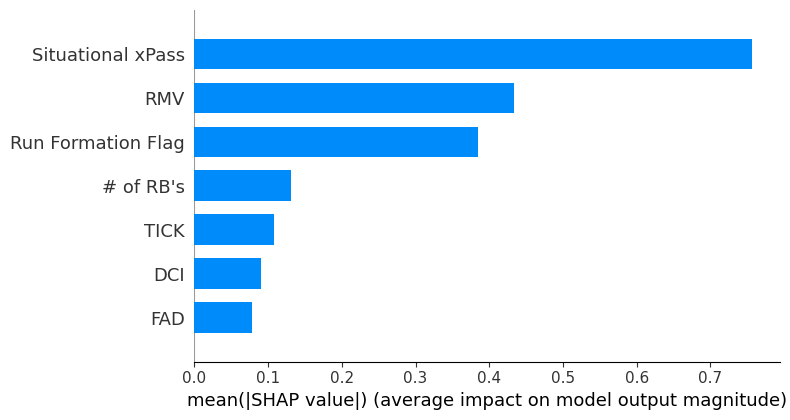

In [62]:
shap_values = shap.TreeExplainer(best_model).shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")

In [63]:
len(final_features)

7

In [64]:
train_data[['ipa','tempo','pass']].corr()

,ipa,tempo,pass
ipa,1.000000,-0.093232,-0.002706
tempo,-0.093232,1.000000,0.195393
pass,-0.002706,0.195393,1.000000


In [65]:
#train_data['backfield_ind'] = 9*train_data['QB_RB1_offset']/.1*train_data['n_offense_backfield']

In [66]:
#train_data['nf_offset'] = 10*train_data['neg_Formations']-train_data['QB_RB1_offset']

In [67]:
train_data[final_features+['db_ct','weight_all_sum','pass']].corr()

,Situational xPass,FAD,# of RB's,RMV,TICK,Run Formation Flag,DCI,db_ct,weight_all_sum,pass
Situational xPass,1.000000,0.156244,-0.278399,0.046734,0.328710,-0.459718,0.387330,0.519984,-0.511785,0.488006
FAD,0.156244,1.000000,-0.242023,-0.104165,0.085052,-0.209160,0.197042,0.102686,-0.126382,0.137291
# of RB's,-0.278399,-0.242023,1.000000,0.028400,-0.163239,0.341777,-0.321354,-0.253941,0.244578,-0.312946
RMV,0.046734,-0.104165,0.028400,1.000000,0.047726,-0.034780,-0.015648,0.029574,-0.022352,0.210648
TICK,0.328710,0.085052,-0.163239,0.047726,1.000000,-0.261266,0.264795,0.335997,-0.384651,0.251815
Run Formation Flag,-0.459718,-0.209160,0.341777,-0.034780,-0.261266,1.000000,-0.386887,-0.375944,0.346762,-0.409078
DCI,0.387330,0.197042,-0.321354,-0.015648,0.264795,-0.386887,1.000000,0.409164,-0.344277,0.309695
db_ct,0.519984,0.102686,-0.253941,0.029574,0.335997,-0.375944,0.409164,1.000000,-0.690911,0.296905
weight_all_sum,-0.511785,-0.126382,0.244578,-0.022352,-0.384651,0.346762,-0.344277,-0.690911,1.000000,-0.294556
pass,0.488006,0.137291,-0.312946,0.210648,0.251815,-0.409078,0.309695,0.296905,-0.294556,1.000000


In [68]:
#filename = 'lgbm.sav'
#pickle.dump(best_model, open(filename, 'wb')) 

### Feature insights

The feature n_offense_backfield (assumedly # of rb's/players in the backfield?) seemingly has two problematic correlations of +/-.33 (with neg_Formations and mean_pairwise_dist), but receiver_alignment_3x2 has a more severe one (nearly .39) with QB_RB1_offset. 

The QB_RB1_offset correlation is likely a product of 3x2 formations either predicting a zero-RB set or an RB lined up as a receiver, giving these two some redundancy.

We gain slightly better validation performance using the n_offense_backfield parameter, and significantly better test performance; while this widens the gap between the performance of the two, it still improves both, which bodes well.

More importantly, our main goal is accomplished: **our features are now more explainable**.